# Geospatial Analysis & Visualization with Python

## Lets Get Started!

### The first step with any python project is to import our packages

* We'll be working with five packages today: Numpy, Pandas, Geopandas, Scipy, and Matplotlib
    * Numpy is a package for dealing with multidmensionsal dataset
    * Pandas is general use package for working with tabular dataset
    * Geopandas is a geospatial exentson for Pandas
        * It to allow us to work with vector data (points, lines, & polgons)
    * Scipy is a statical pagckage
        * It will alow us to do linear regression and calculate chisquare
    * Matplotlib is a powerful plotting library that can be used to make visualizations

In [789]:
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import matplotlib.pyplot as plt
%matplotlib notebook

# Now we can load the data

# Lets start with the records of police killings

* We'll load the Police Killing Data as a "DataFrame" using pandas
    * Then we'll convert it into a "GeoDataFrame" using Geopandas
        * To do this, we must assign the "geometry".  In this case its point data, and the coordinates are in lat/long
        * Then we need to assign a Coordiante Reference System (CRS) manually
            * ESPG is a standardized code that is used to represent CRSs.
            * 'espg:4326' is for the refers to the WGS 1984 datum, which our latitude/longitude data is based in.
                * This is a CRS that is widely used by many web-based platforms because like Google Maps and Mapbox
                * The original only had addresses, not coordinates, so we used a webservice (Mapbox) to generate the coordinates of our addresses
* Once we have the data loaded, calling .head() will give us a "preview" of our dataset

In [790]:
# We import the Police Killings file, and set the incident ID as the index
police_Killings_Tabular = pd.read_csv('Data/PoliceKillings.csv',
                                      parse_dates=['date'],
                                      index_col=['id_incident']
                                     )

# We can then convert the pandas dataframe into a geopandas "GeodataFrame"
police_Killings = gpd.GeoDataFrame(police_Killings_Tabular,
    geometry=gpd.points_from_xy(police_Killings_Tabular.longitude,
                                police_Killings_Tabular.latitude
                               )
                                  )

# Now we can assign a CRS
WGS_1984={'init' :'epsg:4326'}
police_Killings.crs = WGS_1984

# Lets sort the incidents by date and then take a quick look.
police_Killings=police_Killings.sort_values(by='date')
police_Killings.head()

,date,day_week,prov,city_town,postal_code,location_type,id_victim,Name,age,gender,...,taser_deployed,injured_officer,excited_delirium,mentral_distress_disorder,substance_abuse,summary,latitude,longitude,geocoding_Notes,geometry
id_incident,,,,,,,,,,,,,,,,,,,,,
416,2000-01-01,Sat,ON,Toronto,M5B 1W8,Urban,0416-V1,*****,26.0,Male,...,No,No,No,No,No,Henry Musaka entered a hospital emergency room...,43.65363,-79.37736,NaN,POINT (-79.37736 43.65363)
170,2000-01-07,Fri,AB,Edmonton,T5R 1A1,Urban,0170-V1,*****,28.0,Male,...,No,Unknown,No,Unknown,Yes,"Long Duy Hoang, also known as ‚ÄúCrazy Jimmy,‚...",53.52191,-113.57569,NaN,POINT (-113.57569 53.52191)
413,2000-01-30,Sun,ON,Toronto,M4X 1C7,Urban,0413-V1,*****,49.0,Male,...,Unknown,No,No,Unknown,Yes,"Officers responding to ""gun call"" at a rooming...",43.66646,-79.37113,NaN,POINT (-79.37113 43.66646)
435,2000-04-07,Fri,ON,Mississauga,L4T 1T8,Urban,0435-V1,*****,48.0,Male,...,No,No,No,Unknown,Yes,Police were responding to a 911 call reporting...,43.72063,-79.63149,NaN,POINT (-79.63149 43.72063)
266,2000-04-11,Tue,BC,Williams Lake,V2G 1N1,Urban,0266-V1,*****,67.0,Male,...,No,No,No,Unknown,Yes,There was a struggle between Paulsey (Paul) Al...,52.12859,-122.13387,NaN,POINT (-122.13387 52.12859)


# Now we'll load some data from the 2016 Census

* We have a tabular dataset of population data.  We'll load that using pandas

In [791]:
# We'll import the tabualr census data with pandas
Census_Tabular = pd.read_csv('Data/Census.csv',index_col=['PRUID'])
Census_Tabular.head()

,prov,Total,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Caucasian
PRUID,,,,,,,,,,,,,,,,
1,CA,35151728,1924635,1577060,1198545,780125,447320,523235,313260,264305,188710,92920,132090,232375,1673780,25803368
10,NL,519716,2645,2325,2350,1385,635,1375,335,220,75,60,145,255,45725,462186
11,PE,142907,925,2570,825,670,255,585,145,215,210,110,50,85,2735,133527
12,NS,923598,7905,8645,21910,3400,1685,8115,1195,1540,1540,695,635,1390,51490,813453
13,NB,747101,2535,3925,6995,1975,1285,2960,1230,735,1685,230,300,680,29380,693186


* We also have a provincial boundary shapefile that we can load with geopandas.
    * Shapefile are used to store georphric data.  They already have projections and coordiantes associated with them.
    * Geopandas has similar functionality to pandas.  But the read_file() method had less options, so we have to set the index manually.

In [792]:
# We'll import provincial boundaries using geopandas
Provincial_Boundaries = gpd.read_file('Data/Provincial_Boundaries.shp').set_index('PRUID')
Provincial_Boundaries.head()
# Provincial_Boundaries = Provincial_Boundaries.drop(['PRENAME','PRFNAME','PREABBR','PRFABBR','AREA_LCC','AREA_AEA','Area_Merc'],axis=1)
# Provincial_Boundaries.geometry = Provincial_Boundaries.simplify(100)
# Provincial_Boundaries.to_file('Data/Provincial_Boundaries.shp')
# Provincial_Boundaries.index

,PRNAME,geometry
PRUID,,
10,Newfoundland and Labrador,"MULTIPOLYGON (((8307365.589 2582136.711, 83083..."
11,Prince Edward Island,"MULTIPOLYGON (((8435711.754 1679935.966, 84366..."
12,Nova Scotia,"MULTIPOLYGON (((8470851.646 1624745.011, 84717..."
13,New Brunswic,"MULTIPOLYGON (((8176224.537 1722553.460, 81763..."
24,Quebec,"MULTIPOLYGON (((8399709.494 2261445.703, 84005..."


# We want to join the tabular census data to the provincial boundary file.

* This will let us map the disparity by province and do a more detailed analysis

* PRUID is a "unique identifier" that represents the provinces.

    * Since both have the PRUID set as the index, we don't need to specify a join key.

In [793]:
Test_Join = Provincial_Boundaries.join(Census_Tabular)
Test_Join.head()

,PRNAME,geometry,prov,Total,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Caucasian
PRUID,,,,,,,,,,,,,,,,,,
10,Newfoundland and Labrador,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Prince Edward Island,"MULTIPOLYGON (((8435711.754 1679935.966, 84366...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Nova Scotia,"MULTIPOLYGON (((8470851.646 1624745.011, 84717...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,New Brunswic,"MULTIPOLYGON (((8176224.537 1722553.460, 81763...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,Quebec,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# But our join fails :(

* ## Notice the NaN values

* Wonder Why?
    * Lets look at the index for both files?  Maybe we have a datatype missmatch?

In [794]:
print(Provincial_Boundaries.index.dtype)
print(Census_Tabular.index.dtype)

object
int64


## Sure enough!  The Provincial_Boundaries index is an "object", not an integer.

* We can fix that easily and then do the join!
    * We just need to change the datatype of the Provincial_Boundaries layer.

* ## How could we do this?
    * Hint The anser is in the cell above!!

In [795]:
dtype = 'int64'
Provincial_Boundaries.index = Provincial_Boundaries.index.astype(dtype)
Provincial_Boundaries = Provincial_Boundaries.join(Census)
Provincial_Boundaries.head()

,PRNAME,geometry,prov,Total,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Caucasian
PRUID,,,,,,,,,,,,,,,,,,
10,Newfoundland and Labrador,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",NL,519716,2645,2325,2350,1385,635,1375,335,220,75,60,145,255,45725,462186
11,Prince Edward Island,"MULTIPOLYGON (((8435711.754 1679935.966, 84366...",PE,142907,925,2570,825,670,255,585,145,215,210,110,50,85,2735,133527
12,Nova Scotia,"MULTIPOLYGON (((8470851.646 1624745.011, 84717...",NS,923598,7905,8645,21910,3400,1685,8115,1195,1540,1540,695,635,1390,51490,813453
13,New Brunswic,"MULTIPOLYGON (((8176224.537 1722553.460, 81763...",NB,747101,2535,3925,6995,1975,1285,2960,1230,735,1685,230,300,680,29380,693186
24,Quebec,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",QC,8164361,90335,99505,319230,34910,133920,213740,62825,32405,8055,4575,9840,23040,182890,6949091


# Before we dig into the data, lets make a quick map.

## Our Layers need to be in the same coordinate system to match up properly on a map!

* We can re-project the police_Killings layer using the .to_crs function to set the CRS to that of the Provinces
    * The provinces layer uses the Canada Lambert Conformal Conic projection (LCC).  This is the standard projection used by stats canada and is ideally suited for displaying the whole of country.
        
### Once both datasets are in the same coordinate system, we can make a map!
* First we must define a plot, using the matplotlib.pyplot package.  We imported this earlier as "plt"
    * We use the plt.subplots() to create a figure, and we can define how big we want it to be
* Geoapndas can then use the .plot() fucntion to create a map using matplotlib.
    * We simply tell it what axis to draw the plot on with ax="axes"
    * Then set a few other parameters:
        * We just want the provinces as a grey background so we can set the color
        * We want to classify killings by race, so we can set race as the column.  THen we can add a legend to aid interpretation of the data

C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<IPython.core.display.Javascript object>


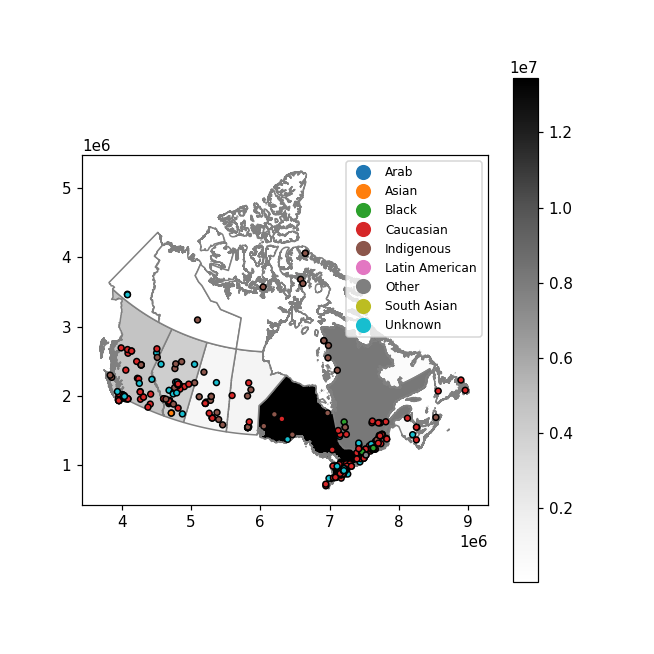

In [796]:
# We can use .to_crs() to create a police killings layer with the same projection as the provinces layer.
police_Killings = police_Killings.to_crs(Provinces.crs)

# Now, we can create a figure using matplotlib (plt), first we define the figure and the size
fig,axes=plt.subplots(
    figsize=(6,6)
)

# Now we can add the provinces using the .plot() function.  We set the plotting axes and give it a grey color
cb = Provincial_Boundaries.plot(
    ax=axes,
#     alpha=.5,
    column='Total',
    cmap = 'Greys',
    edgecolor='grey',
    legend=True,
)

# Then we add the police_Killings_LCC.  We'll set the column to 'race', so we can disply by race,
# give the point markers a few more parameters, and add them to a legend
police_Killings.plot(
    ax=axes,
    column='race',
    edgecolor='k',
    markersize=15,
    legend=True,
    legend_kwds={'loc': 'upper right','fontsize':8}
)

## And now you've made your first map with python!

# But its an ugly map :(

* It doesn't look great.  This is just the quick and dirty way to look ata data

* To make things more presentable, we'll have to be more explicit in setting up our map.  But that's a task for later.


# For now, lets move on and look at the dataset in more detail.

* Pandas & Geopandas have some nice features to quickly summarize our dataset.
* We can use .count() to get the total # incidents.
    * Callling .count() as is, will give us a list of all the columns, and a count for each.  We can see most collumns are "full" but in the "geocoding_Notes" column, we can see that 4 points don't have coordinates associated with their address.  This suggests there was an error in the data entry process.  We don't need to worry about this though.    

In [797]:
police_Killings.count()

date                             462
day_week                         462
prov                             462
city_town                        462
postal_code                      462
location_type                    462
id_victim                        462
Name                             462
age                              455
gender                           462
race                             462
ethnic_ancestry                  107
immigrant_refugee_naturalized    462
armed_type                       462
cause_death                      462
taser_deployed                   462
injured_officer                  462
excited_delirium                 462
mentral_distress_disorder        462
substance_abuse                  462
summary                          462
latitude                         458
longitude                        458
geocoding_Notes                    4
geometry                         462
dtype: int64

* We can use .mean(), .min(), etc. followed by ['age'] to get some vital statistics on the age of victims.

In [798]:
print('Age Distribution of Victims')
print()
print('Mean:                ',
      police_Killings.mean()['age']
     )
print()
print('Standard Deviation:  ',
      police_Killings.std()['age']
     )
print()
print('Youngest:            ',
      police_Killings.max()['age']
     )
print()
print('Oldest:              ',
      police_Killings.min()['age']
     )

Age Distribution of Victims

Mean:                 36.73186813186813

Standard Deviation:   11.775739256991544

Youngest:             77.0

Oldest:               15.0


# We can resample our data to look for trends
* The date column is a special type of data that allows us to resample our data by year, month, etc
* The dataset has to be in order by date for this to work (we did this alread).

<IPython.core.display.Javascript object>


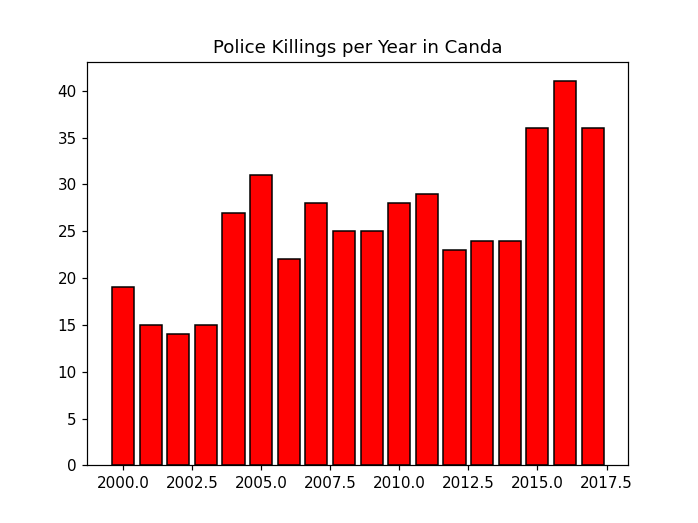

Text(0.5, 1.0, 'Police Killings per Year in Canda')

In [799]:
Resampled = police_Killings.set_index('date').resample('Y').count()


plt.figure()
plt.bar(
    Resampled.index.year,
    Resampled['id_victim'],
    edgecolor='black',
    facecolor='#FF0000'
)
plt.title('Police Killings per Year in Canda')

# We can group our data to look for patterns too.

* the .groupby() function can accept one or multple paramters to group our dataset by.
    * This allows us to create complex queries if we want.
* We can have to follow up with .count(), .mean(), etc.
    * This tells us "how" to aggregate

<IPython.core.display.Javascript object>


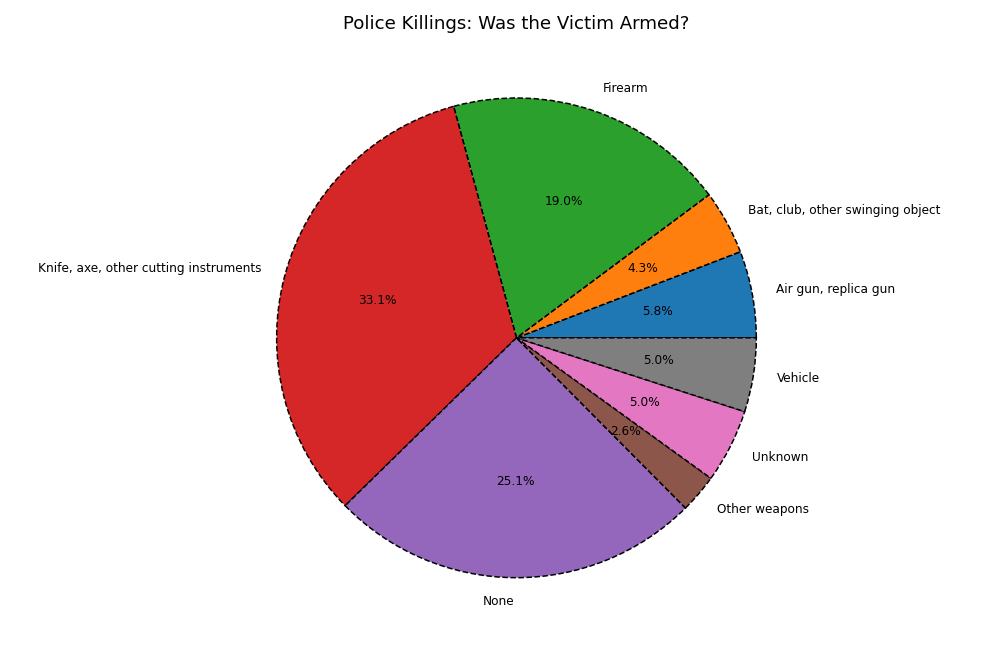

In [800]:
fig,ax = plt.subplots(figsize=(9,6))


Armed = police_Killings.groupby(['armed_type']).count()
ax.pie(
    Armed['id_victim'],
    labels=Armed.index,
    textprops={'fontsize': 8},
    autopct='%1.1f%%',
    wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'}
)
ax.set_title('Police Killings: Was the Victim Armed?')
plt.tight_layout()

In [801]:
police_Killings.groupby(['gender','mentral_distress_disorder']).count()

date  day_week  prov  city_town  \
gender mentral_distress_disorder                                    
Female No                            1         1     1          1   
       Unknown                       7         7     7          7   
       Yes                           6         6     6          6   
Male   No                           34        34    34         34   
       Unknown                     227       227   227        227   
       Yes                         187       187   187        187   

                                  postal_code  location_type  id_victim  Name  \
gender mentral_distress_disorder                                                
Female No                                   1              1          1     1   
       Unknown                              7              7          7     7   
       Yes                                  6              6          6     6   
Male   No                                  34             34         34    34   
       Unknown                            227            227        227   227   
       Yes                                187            187        187   187   

                                  age  race  ...  cause_death  taser_deployed  \
gender mentral_distress_disorder             ...                                
Female No                           1     1  ...            1               1   
       Unknown                      7     7  ...            7               7   
       Yes                          6     6  ...            6               6   
Male   No                          34    34  ...           34              34   
       Unknown                    221   227  ...          227             227   
       Yes                        186   187  ...          187             187   

                                  injured_officer  excited_delirium  \
gender mentral_distress_disorder                                      
Female No                                       1                 1   
       Unknown                                  7                 7   
       Yes                                      6                 6   
Male   No                                      34                34   
       Unknown                                227               227   
       Yes                                    187               187   

                                  substance_abuse  summary  latitude  \
gender mentral_distress_disorder                                       
Female No                                       1        1         1   
       Unknown                                  7        7         7   
       Yes                                      6        6         6   
Male   No                                      34       34        33   
       Unknown                                227      227       225   
       Yes                                    187      187       186   

                                  longitude  geocoding_Notes  geometry  
gender mentral_distress_disorder                                        
Female No                                 1                0         1  
       Unknown                            7                0         7  
       Yes                                6                0         6  
Male   No                                33                1        34  
       Unknown                          225                2       227  
       Yes                              186                1       187  

[6 rows x 23 columns]

# We're intersted in a specific question.  What's the distribution of police killings by race?


In [802]:
police_Killings.groupby(['race']).count()['date'].sort_values()

race
Latin American      3
Arab                5
Other               5
South Asian        10
Asian              15
Black              43
Indigenous         70
Unknown            99
Caucasian         212
Name: date, dtype: int64

# The racial demographics of Canada aren't evenly split however!

* We need to Normalize our data by population statistics.

* Lets look at our census data again


In [803]:
Provincial_Boundaries[Census_Tabular.columns]

,prov,Total,South Asian,Chinese,Black,Filipino,Latin American,Arab,Southeast Asian,West Asian,Korean,Japansese,"Visible minority, n.i.e",Mixed,Indigenous,Caucasian
PRUID,,,,,,,,,,,,,,,,
10,NL,519716,2645,2325,2350,1385,635,1375,335,220,75,60,145,255,45725,462186
11,PE,142907,925,2570,825,670,255,585,145,215,210,110,50,85,2735,133527
12,NS,923598,7905,8645,21910,3400,1685,8115,1195,1540,1540,695,635,1390,51490,813453
13,NB,747101,2535,3925,6995,1975,1285,2960,1230,735,1685,230,300,680,29380,693186
24,QC,8164361,90335,99505,319230,34910,133920,213740,62825,32405,8055,4575,9840,23040,182890,6949091
35,ON,13448494,1150415,754545,627715,311670,195955,210435,133860,154670,88940,30835,97970,128590,374395,9188499
46,MB,1278365,42060,22540,30340,79820,9895,5030,8565,2695,4375,1850,3200,6480,223310,838205
47,SK,1098352,29965,15540,14925,32340,4190,4300,5740,2070,1880,955,1145,2815,175020,807467
48,AB,4067175,230925,158200,129395,166200,55085,56700,43985,20980,21275,12165,9905,28355,258640,2875365


# The first row contains the total values for the whole country.  We can use this to calculate a police killing rate.

* But the Canadian Census' racial categories don't match up perfectly with the police violence dataset's racial
* How can we work around this?
    * We have the largest three groups in the police killing set: White, Indigenous, and Black.  So we can work with them as is
    * The other races make up a small portion of total killings.  And we can't be entirely sure how the CBC defined their groupings.  So, lets add a new category: "All_Other_Minority_Groups"
    
* We'll do this for both the provincial boundaires and the police_Killings
    * For the police killings, we'll leave the unknow records alone

In [804]:
All_Other_Minority_Groups=['South Asian', 'Chinese', 'Filipino','Latin American',
 'Arab', 'Southeast Asian', 'West Asian', 'Korean',
'Japansese', 'Visible minority, n.i.e', 'Mixed']
Provincial_Boundaries['All_Other_Minority_Groups']=Provincial_Boundaries[All_Other_Minority_Groups].sum(axis=1)
Provincial_Boundaries=Provincial_Boundaries.drop(All_Other_Minority_Groups,axis=1)

All_Other_Minority_Groups=['Latin American', 'Arab', 'Other', 'South Asian', 'Asian']
police_Killings['race'] = police_Killings['race'].replace(to_replace=All_Other_Minority_Groups,value='All_Other_Minority_Groups')


# From here, we can calculate the police killing rate.

* Dividing the total number of killings by the population gives us ...

In [805]:
Races = ['Indigenous','Black','Caucasian','All_Other_Minority_Groups']
Race_Breakdown = police_Killings.groupby(['race']).count()['id_victim']
Can_Pop = Provincial_Boundaries[Races].sum()

Racial_Rates = Race_Breakdown.T[Races]/Can_Pop
Racial_Rates['Average']=Race_Breakdown.T[Races].sum()/Can_Pop.sum()
print(Racial_Rates)
# police_Killings.groupby(['race']).count()['date'].sort_values()

race
Indigenous                   0.000042
Black                        0.000036
Caucasian                    0.000008
All_Other_Minority_Groups    0.000006
Average                      0.000010
dtype: float64


# This number isn't that meaningful though.  It represents the number of killings "per person" over the whole study period.

## Lets convert the rate to a more meaninful unit.  Killings / Million Residents / Year

### The date record is a "date" object.
* It has some added functionality like being able to query the the year, month, day

### How might we use this info to calculate our police killing rate?

<IPython.core.display.Javascript object>


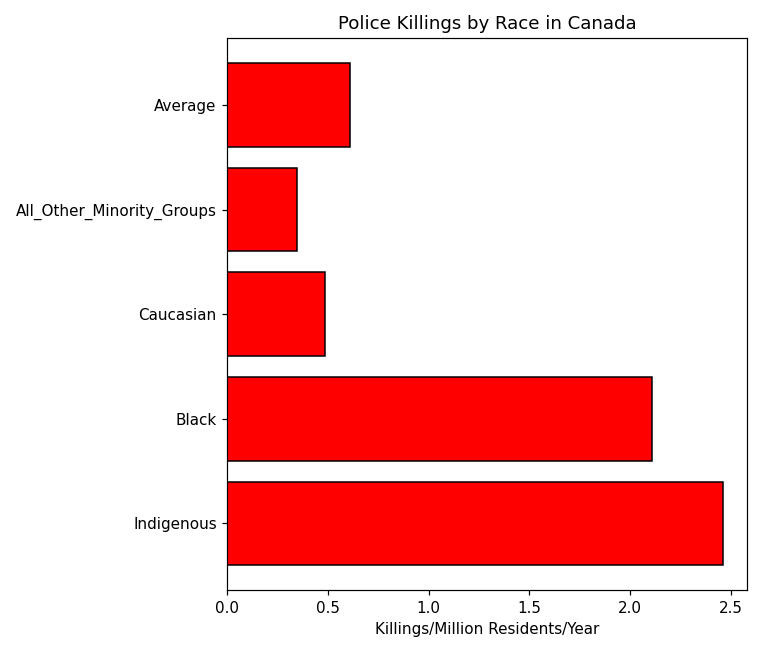

In [806]:
First_Year = police_Killings['date'].min().year
Last_Year = police_Killings['date'].max().year

Scale = 1e6
Duration = Last_Year-First_Year
rate_Conversion = Scale /  Duration

# Racial_Rates = Racial_Rates * rate_Conversion
# Racial_Rates

fig, ax = plt.subplots(figsize = (7,6))
ax.barh(
    Racial_Rates.index,
    Racial_Rates.values * rate_Conversion,
    facecolor='#FF0000',
    edgecolor='black',
    linewidth=1
)
ax.set_title('Police Killings by Race in Canada')
ax.set_xlabel('Killings/Million Residents/Year')
plt.tight_layout()

# The Police killing rates are 5x higher for Indigenous people and 4x higher for Black people than white people.

## This is an abhorent example of systemic racism in Canadian Policing.


## Now we  want to normalize by provincial demographics.

* We have a few more steps to go through first.
    * The police killings and census data use different abbreviations.  To do a join our dataset with the census data we'll need to assign an new abbreviaton
    * We'll us a dictionary to do this
* Then we can summarize the killings by province and join it to the Provinces_Join layer

## Now we can summarize the killings by province and join it to the Provinces_Join layer
* Note Prince Edward Island doesn't have any.

In [807]:

race_by_Province = police_Killings.groupby(['prov','race']).count()
# print(race_by_Province)
race_by_Province = race_by_Province['date'].unstack()#reset_index(level=0)
race_by_Province['Total'] = race_by_Province.sum(axis=1)

# # Some provines/groups don't have any records.  Those are given NaN values, and need to be repalced with zeros
# race_by_Province = race_by_Province.fillna(0)

# Temp = Provincial_Boundaries.copy()
Provincial_Boundaries=Temp.copy()

for col in Races:
    Provincial_Boundaries = Provincial_Boundaries.join(race_by_Province[col],on='prov',rsuffix='_Killings')

for col in ['Unknown','Total']:
    Provincial_Boundaries = Provincial_Boundaries.join(race_by_Province[col],on='prov',rsuffix='_Killings')
Provincial_Boundaries
    
# # Provincial_Boundaries = Provincial_Boundaries.join(race_by_Province['Unknown'],on='prov',rsuffix='_Killings')
Provincial_Boundaries[[x+'_Killings' for x in Races]]=Provincial_Boundaries[[x+'_Killings' for x in Races]].fillna(0)
Provincial_Boundaries['Total_Killings']=Provincial_Boundaries['Total_Killings'].fillna(0)
Provincial_Boundaries[['Unknown' for x in Races]].fillna(0)

Provincial_Boundaries.head()

,PRNAME,geometry,prov,Total,Black,Indigenous,Caucasian,All_Other_Minority_Groups,Indigenous_Killings,Black_Killings,Caucasian_Killings,All_Other_Minority_Groups_Killings,Unknown,Total_Killings
PRUID,,,,,,,,,,,,,,
10,Newfoundland and Labrador,"MULTIPOLYGON (((8307365.589 2582136.711, 83083...",NL,519716,2350,45725,462186,9455,0.0,0.0,3.0,0.0,NaN,3.0
11,Prince Edward Island,"MULTIPOLYGON (((8435711.754 1679935.966, 84366...",PE,142907,825,2735,133527,5820,0.0,0.0,0.0,0.0,NaN,0.0
12,Nova Scotia,"MULTIPOLYGON (((8470851.646 1624745.011, 84717...",NS,923598,21910,51490,813453,36745,1.0,0.0,2.0,0.0,NaN,3.0
13,New Brunswic,"MULTIPOLYGON (((8176224.537 1722553.460, 81763...",NB,747101,6995,29380,693186,17540,0.0,0.0,3.0,0.0,1.0,4.0
24,Quebec,"MULTIPOLYGON (((8399709.494 2261445.703, 84005...",QC,8164361,319230,182890,6949091,713150,8.0,8.0,53.0,3.0,15.0,87.0


# Lets calcualte the police killing rate (PKR) on the provincial level


<IPython.core.display.Javascript object>


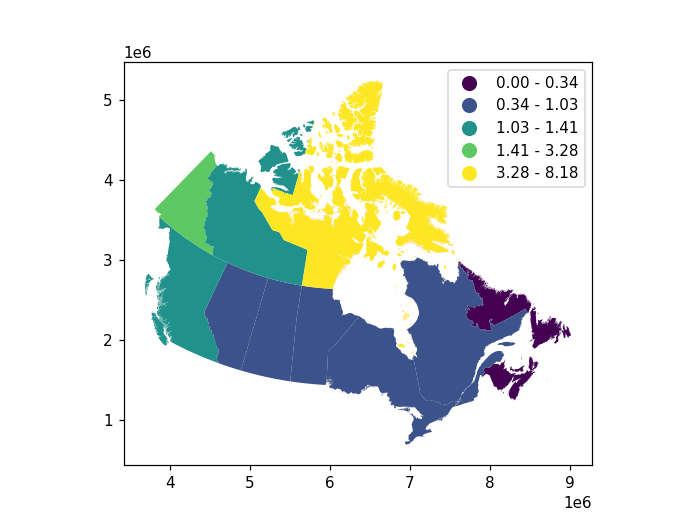

In [811]:
Provincial_Boundaries['PKR']=Provincial_Boundaries['Total_Killings']/Provincial_Boundaries['Total']*rate_Conversion

Provincial_Boundaries.plot(column='PKR',legend=True,scheme='naturalbreaks')

# Nunavut has a huge problem.  Its not a conicidence that the population is 75% Inuit.

# Now we can calculate a Police Killings Discrimination Index:

* For this, we'll compare the rates of police killings of black and indigenous people to white people

* We'll use the following equations:


\begin{align}
\ Wr & = (\frac{White Killings}{White Population}) * Rate Conversion\\
\ BIr & = (\frac{Black Killings + Indigenous Killings}{Black Population + Indigenous Population}) * Rate Conversion\\
\ PKDI & = BIr - Wr\\
\end{align}

* This will hightlight the disparities in police killings
    * We'll classify the data using the following scheme:
    
        * "Slight Bias": -0.483293 to 0.483293 - This is the rate killings of whites.  Within these ranges, differences might be due to presence or lacktherof of a certain groups 
        * "Moderate Bias": 0.483293 to 0.773119 - Greater than the white rate, less than the national average
        * "Severe Bias": 0.773119 to 2.314174 - Greater than the national rate, less than the indigenouos rate
        * "Extreme Bias: 2.314174 to 10 - Greater than the national indigenous rate
    

In [823]:
Provincial_Boundaries['Wr']=Provincial_Boundaries['Caucasian_Killings']/Provincial_Boundaries['Caucasian']*rate_Conversion
Provincial_Boundaries['BIr']=(Provincial_Boundaries['Indigenous_Killings']+Provincial_Boundaries['Black_Killings'])/(Provincial_Boundaries['Indigenous']+Provincial_Boundaries['Black'])*rate_Conversion

Provincial_Boundaries['PKDI'] = Provincial_Boundaries['BIr'] - Provincial_Boundaries['Wr']

Provincial_Boundaries['PKDI']=Provincial_Boundaries['PKDI'].fillna(0)


bins = [-0.483293,0.483293,0.773119,2.314174,10]
labels = ['Minimal Biaias','Moderate Bias','Severe Bias','Extreme Bias']
Provincial_Boundaries['PKDI_Classes']=(pd.cut(Provincial_Boundaries['PKDI'],bins=bins,labels=labels))


print(Provincial_Boundaries[['prov','PKDI','PKDI_Classes']].sort_values(by='PKDI'))

      prov      PKDI    PKDI_Classes
PRUID                               
10      NL -0.381817  Minimal Biaias
13      NB -0.254579  Minimal Biaias
11      PE  0.000000  Minimal Biaias
12      NS  0.656784   Moderate Bias
48      AB  1.377439     Severe Bias
24      QC  1.425764     Severe Bias
35      ON  1.755767     Severe Bias
59      BC  2.073789     Severe Bias
46      MB  2.361831    Extreme Bias
61      NT  2.720792    Extreme Bias
47      SK  3.115161    Extreme Bias
60      YT  6.949029    Extreme Bias
62      NU  9.524535    Extreme Bias


# Lets map the patterns

<IPython.core.display.Javascript object>


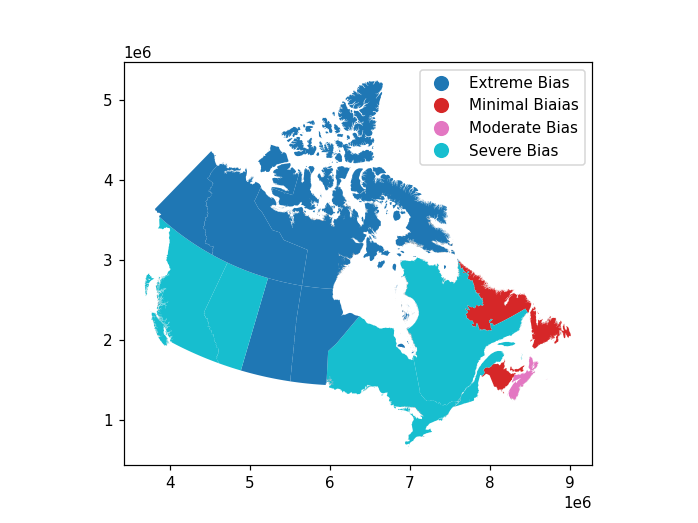

In [761]:
Provincial_Boundaries.plot(column='PKDI_Classes',legend=True)

# Lets combine this, with what else we've learned to make a detailed infographic on police violence in Canada

## Matplotlib alows us to be very specific in determining our layout with gridspec.

### We can create a large plot and define specifically what we want.

* We'll have two maps, showing the PKR and the PKDI on the left
* Then we'll add some smaller plots on the right showing the annual trend, national PKR by race, and some pie charts

<IPython.core.display.Javascript object>


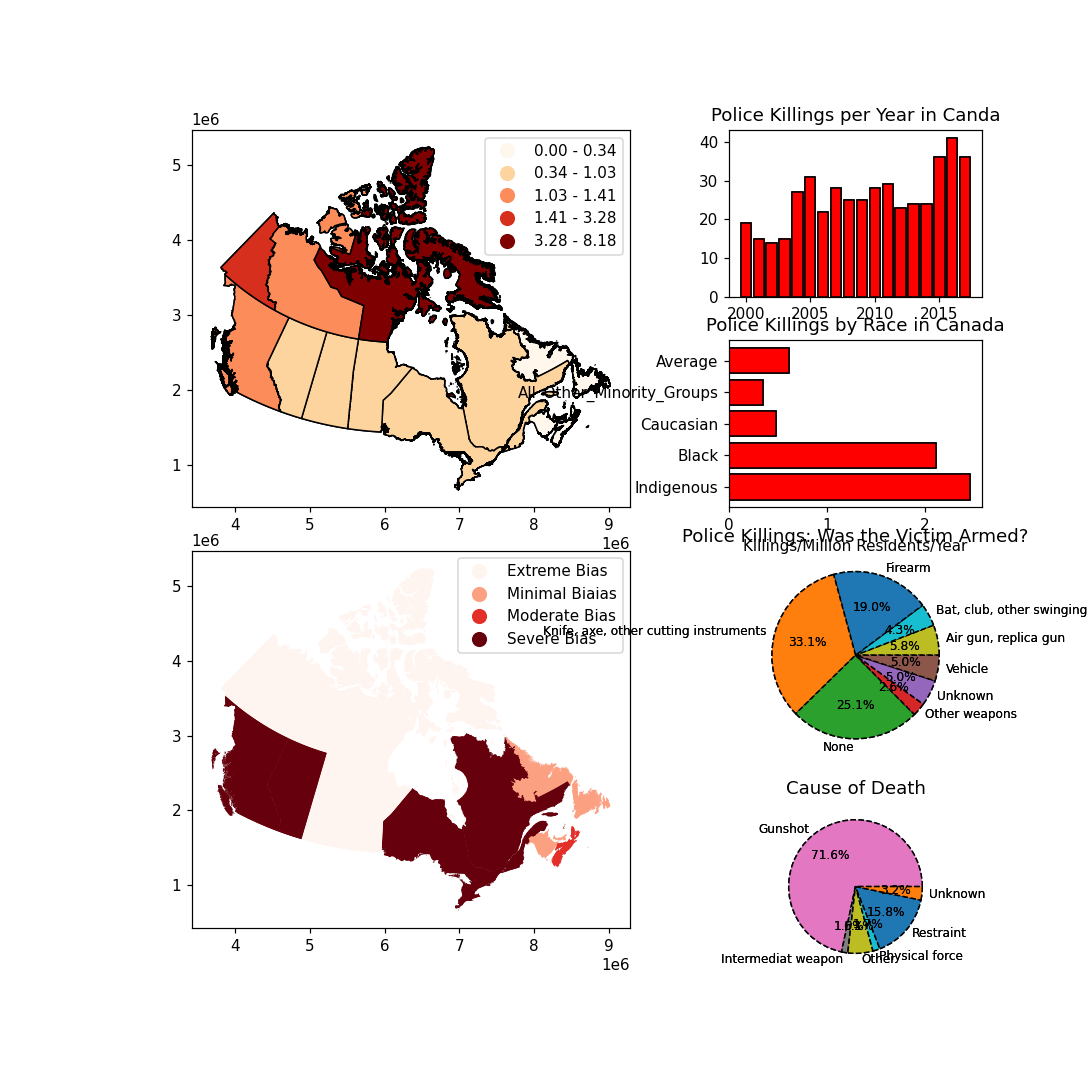

In [838]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(100,100)

PKR_Map = fig.add_subplot(gs[0:45 , 0:65])
PKDI_Map = fig.add_subplot(gs[50:95, 0:65])

Annual_Trend = fig.add_subplot(gs[0:20, 70:])
PKR_national = fig.add_subplot(gs[25:45, 70:])
Pie_1 = fig.add_subplot(gs[50:75, 70:])
Pie_2 = fig.add_subplot(gs[80:100, 70:])

# Now we can add things to the figure
* First lets do the maps

In [840]:
Provincial_Boundaries.plot(ax=PKR_Map,
                           column='PKR',
                           legend=True,
                           cmap = 'OrRd',
                           edgecolor='black',
                           scheme='naturalbreaks')

Provincial_Boundaries.plot(ax=PKDI_Map,
                           column='PKDI_Classes',
                           legend=True,
                           cmap = 'Reds',)

PKR_national.barh(
    Racial_Rates.index,
    Racial_Rates.values * rate_Conversion,
    facecolor='#FF0000',
    edgecolor='black',
    linewidth=1
)
PKR_national.set_title('Police Killings by Race in Canada')
PKR_national.set_xlabel('Killings/Million Residents/Year')

Annual_Trend.bar(
    Resampled.index.year,
    Resampled['id_victim'],
    edgecolor='black',
    facecolor='#FF0000'
)
Annual_Trend.set_title('Police Killings per Year in Canda')


Armed = police_Killings.groupby(['armed_type']).count()
Pie_1.pie(
    Armed['id_victim'],
    labels=Armed.index,
    textprops={'fontsize': 8},
    autopct='%1.1f%%',
    wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'}
)
Pie_1.set_title('Police Killings: Was the Victim Armed?')
# plt.tight_layout()


COD = police_Killings.groupby(['cause_death']).count()
Pie_2.pie(
    COD['id_victim'],
    labels=COD.index,
    textprops={'fontsize': 8},
    autopct='%1.1f%%',
    wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'}
)
Pie_2.set_title('Cause of Death')
# plt.tight_layout()
plt.savefig('InfoGraphic.png')

In [397]:
Temp = police_Killings.copy()

for r in Temp['armed_type'].unique():
    replace = {'Air gun, replica gun':'Firearm',
              'Bat, club, other swinging object':'Other weapons',
            'Vehicle':'Other weapons',
              'Knife, axe, other cutting instruments':'Knife',
              'Unknown':'None'
              }
    if r in replace.keys():
        Temp.loc[Temp['armed_type']==r,'armed_type']=replace[r]
        

Armed = Temp.groupby(['race','armed_type']).count()['date'].unstack().fillna(0)#/\
# (Armed.T/Armed.sum(axis=1))[['Caucasian','Black','Indigenous']]
Observed = Armed.T[['Caucasian','Black','Indigenous']]

Expected = Observed.copy()

Expected = Armed.T.sum(axis=1).values[:,np.newaxis]*\
       Can_Pop[['Caucasian','Black','Indigenous']].values/Can_Pop['Total'].values

# police_Killings.groupby('race').count()['date'].values

In [398]:
# police_Killings.groupby('immigrant_refugee_naturalized').count()
print(Expected)

print(Observed)

print(scipy.stats.chisquare(Observed,Expected))

Yearly=police_Killings.set_index('date').resample('Y').count()
# print(Yearly)

reg=scipy.stats.linregress(Yearly.index.year,Yearly.race)
# plt.figure()
ax2.bar(Yearly.index.year,Yearly.race,edgecolor='k')
print(reg)
ax2.plot(Yearly.index.year,Yearly.index.year*reg.slope+reg.intercept,color='k',
         label = 'Slope = '+str(np.round(reg.slope,2))+' Killings per Year '\
        ' P = '+str(np.round(reg.pvalue,2)))
ax2.legend()

[[ 84.41654191   3.92107822   5.47582469]
 [112.31070359   5.21673885   7.28522763]
 [102.03390718   4.73939019   6.61860549]
 [ 40.37312874   1.87529828   2.61887268]]
race           Caucasian  Black  Indigenous
armed_type                                 
Firearm             55.0   10.0        19.0
Knife               68.0   16.0        31.0
None                64.0   12.0        16.0
Other weapons       25.0    5.0         4.0
Power_divergenceResult(statistic=array([ 47.76410091,  48.04336656, 124.62378673]), pvalue=array([2.39040172e-10, 2.08470799e-10, 7.78884256e-27]))
LinregressResult(slope=1.0485036119711042, intercept=-2080.252837977296, rvalue=0.7543604262227599, pvalue=0.0002978828736845745, stderr=0.22810752954681113)


<IPython.core.display.Javascript object>


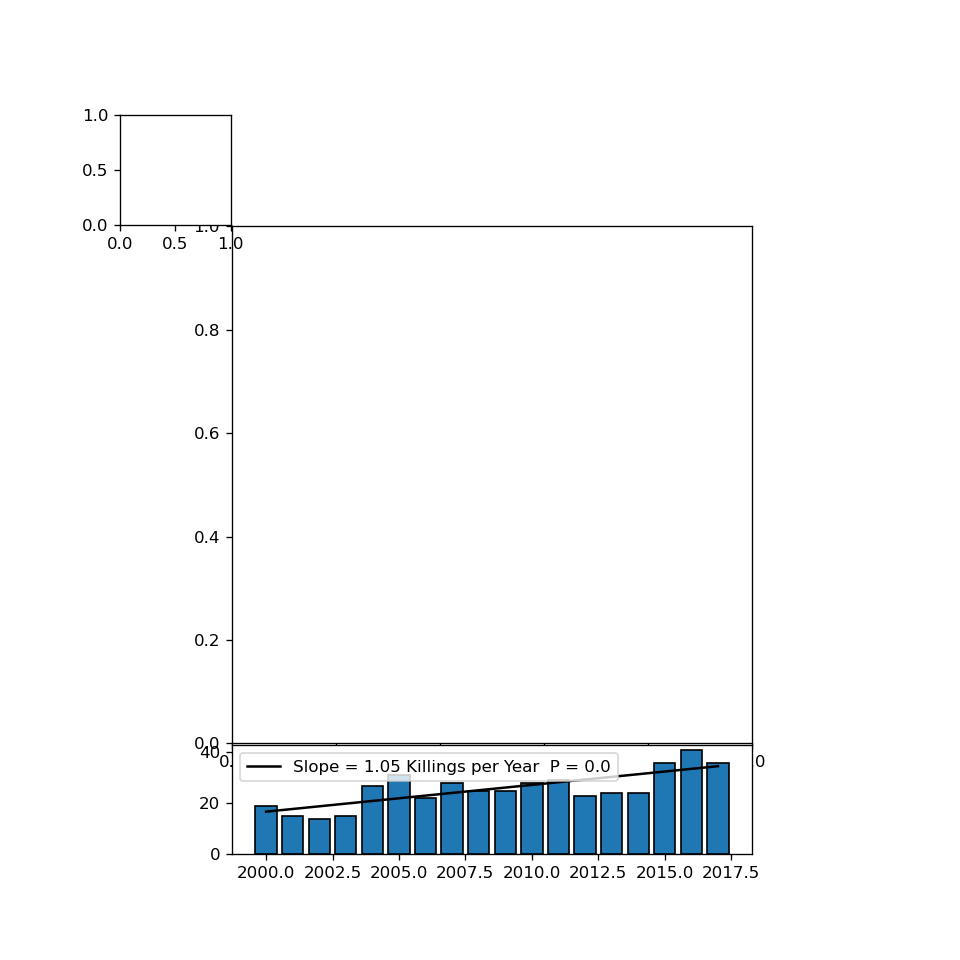

In [396]:



# Provinces_Killings['Indigenous_pct'] = Provinces_Killings['Indigenous']/Provinces_Killings['Total']
# Provinces_Killings['Black_pct'] = Provinces_Killings['Black']/Provinces_Killings['Total']

# Provinces_Killings.plot(ax=ax1,column='Rate',edgecolor='k',legend=True,scheme='natural_breaks')
# # ax3.bar(Provinces_Killings.index,Provinces_Killings['Rate'])
# # ax3.set_xticklabels(Provinces_Killings.index,rotation=30)
# Total = police_Killings.groupby('race').count()
# Rate = []
# Races = ['Black','Indigenous','Caucasian','Asian','South Asian']
# for race in Races:
#     Rate.append((Total['date'].T[race]/Provinces_Killings[race]).values[0]*1e6/17)
# Normalized_Rates = pd.DataFrame(index=Races,data={'Rate':Rate})
# ax4.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
# ax4.set_title('Police Killing Rates in Canada')
# ax4.set_ylabel('Killings/Year/Million Residents')
# for breaks

# Provinces_Join.plot(ax=ax3,column='PDI',edgecolor='k',legend=True)#,scheme='natural_breaks')
# Provinces_Killings.plot(ax=ax2,column='Black_pct',edgecolor='k',legend=True,scheme='natural_breaks')
# plt.suptitle('Police Killing Rates Across Canada')

### Nunavut obviously has a serious problem.  75% of its population is Inuit & its rate is an order of magnitude higher than the other provinces or teritories.

### BC is the worst to of the provinces.  Lets select BC and investigate further.

* For We can select BC using the PREABBR value.
* We'll also re-project into UTM Zone 10 N, this is a more accurate coordinate system for this region

* Then we can look at the racial breakdown of killings in BC using the .groupby function again.
    * We'll create a new dataframe normalizing total killings for different races by total population within those groups
    * Then we can make a barplot highlighting racial biases 


In [327]:
Mental_Health = police_Killings.groupby('mentral_distress_disorder').count()
ax1.pie(Mental_Health['id_victim'],labels=Mental_Health.index,textprops={'fontsize': 8},
        autopct='%1.1f%%',wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'})

([<matplotlib.patches.Wedge at 0x221b7486448>,
 [Text(1.0689927233164507, 0.2593348366426671, 'No'),
  Text(-0.5238883537010176, 0.9672336805841893, 'Unknown'),
  Text(0.28108682195513623, -1.0634802294933186, 'Yes')],
 [Text(0.5830869399907912, 0.14145536544145476, '7.6%'),
  Text(-0.2857572838369186, 0.527582007591376, '50.6%'),
  Text(0.15332008470280156, -0.5800801251781738, '41.8%')])

In [326]:
# ax3.set_title('PD Descrim Rayte')


Provinces_Join.plot(ax=ax,column='PDI',edgecolor='k',legend=True)

# ax2.plot([1,2],[0,1])
# plt.tight_layout()

In [314]:
# 26910
BC = Provinces_Killings.loc[Provinces_Killings.index=='B.C.'].to_crs(26910)
BC_Killings = police_Killings.loc[police_Killings['PREABBR']=='B.C.'].to_crs(26910)
Total_BC = BC_Killings.groupby('race').count()

Rate = []
Races = ['Black','Indigenous','Caucasian','Asian','South Asian']
for race in Races:
    Rate.append((Total_BC['date'].T[race]/BC[race]).values[0]*1e6/17)
Normalized_Rates = pd.DataFrame(index=Races,data={'Rate':Rate})
plt.figure()
plt.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
plt.title('Police Killing Rates in BC')
plt.ylabel('Killings/Year/Million Residents')
plt.savefig('BCPoliceKillings.png')
# print(Total_BC['Black']/BC['Black'])

# fig,ax=plt.subplots(figsize=(6,6))

# BC.plot(ax=ax,color='grey',edgecolor='k')
# BC_Killings.plot(ax=ax,column='race',legend=True)
# print(Canada.head())

# from fiona.crs import from_epsg
# from_epsg(2193)
# # Proj({'init': 'epsg:2193', 'no_defs': True}, preserve_flags=True)

C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


KeyError: 'PREABBR'

## Lets make an infographic for BC, summarizing some of the key points

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(10,10)
ax0 = fig.add_subplot(gs[0:6, 0:6])
BC.plot(ax=ax0,color='grey',edgecolor='k')
BC_Killings.plot(ax=ax0,column='race',legend=True,edgecolor='k')
ax0.axes.get_xaxis().set_visible(False)
ax0.axes.get_yaxis().set_visible(False)
ax0.set_title('Police Killings in BC 2000-2017')


ax1 = fig.add_subplot(gs[1:5, 6:])

Mental_Health = BC_Killings.groupby('mentral_distress_disorder').count()
ax1.pie(Mental_Health['id_victim'],labels=Mental_Health.index,textprops={'fontsize': 8},
        autopct='%1.1f%%',wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'})
ax1.set_title('Was it a Mental Health Crisis?')
# ax1.bar(BC_Year.index,BC_Year.race,width=300,edgecolor='k')
# ax1.set_title('Police Killings by Year in BC')
# ax1.set_ylabel('Number')

ax2 = fig.add_subplot(gs[6:, 0:6])
ax2.bar(Normalized_Rates.index,Normalized_Rates.Rate,edgecolor='k')
ax2.set_title('Police Killing Rates by Race in BC')
ax2.set_ylabel('Killings/Year/Million Residents')
ax2.set_xticklabels(Normalized_Rates.index,rotation=30)

BC_Killings.loc[BC_Killings.armed_type=='Knife, axe, other cutting instruments','armed_type']='Knife/Axe'
BC_Killings.loc[BC_Killings.armed_type=='Bat, club, other swinging object','armed_type']='Bat/Club'
BC_Killings.loc[BC_Killings.armed_type=='Air gun, replica gun','armed_type']='Fake Gun'
BC_Killings.loc[BC_Killings.armed_type=='Unknown','armed_type']='None'
Mental_Health = BC_Killings.groupby('armed_type').count()
ax3 = fig.add_subplot(gs[6:, 6:])
ax3.pie(Mental_Health['id_victim'],labels=Mental_Health.index,textprops={'fontsize': 8},
        autopct='%1.1f%%',wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': 'dashed'})
ax3.set_title('Were They Armed?')


plt.tight_layout()
# ax0 = fig.add_subplot(gs[0:6, 0:6])